Installing Libraries for Parallelization and JIT Compiling Numpy Operations, for fast experimentation.

In [1]:
!pip install -q 'ray[default]' numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.4/600.4 kB 10.0 MB/s eta 0:00:00


## Scikit Learn Functions

Imports

In [2]:
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)
        return self

    def transform(self, X):
        if self.mean_ is None or self.scale_ is None:
            raise Exception("Scaler has not been fitted yet.")

        X_scaled = (X - self.mean_) / self.scale_
        return X_scaled

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X_scaled):
        X_original = (X_scaled * self.scale_) + self.mean_
        return X_original

In [4]:
class LabelEncoder:
    def __init__(self):
        self.classes_ = None

    def fit(self, y):
        self.classes_ = np.unique(y)
        return self

    def transform(self, y):
        if self.classes_ is None:
            raise Exception("LabelEncoder has not been fitted yet.")

        label_map = {label: idx for idx, label in enumerate(self.classes_)}
        y_encoded = np.array([label_map[label] for label in y])
        return y_encoded

    def fit_transform(self, y):
        self.fit(y)
        return self.transform(y)

    def inverse_transform(self, y_encoded):
        if self.classes_ is None:
            raise Exception("LabelEncoder has not been fitted yet.")

        inverse_map = {idx: label for idx, label in enumerate(self.classes_)}
        y_original = np.array([inverse_map[idx] for idx in y_encoded])
        return y_original

In [5]:
class KFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X):
        n_samples = X.shape[0]
        indices = np.arange(n_samples)

        if self.shuffle:
            if self.random_state is not None:
                np.random.seed(self.random_state)
            np.random.shuffle(indices)

        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            val_idx = indices[current:current + fold_size]
            train_idx = np.concatenate([indices[:current], indices[current + fold_size:]])
            yield train_idx, val_idx
            current += fold_size

In [6]:
@nb.njit
def roc_auc_score(y_true, y_scores):
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    positives = np.sum(y_true == 1)
    negatives = np.sum(y_true == 0)

    if positives == 0 or negatives == 0:
        raise ValueError("ROC AUC score is not defined.")

    tpr = [0]
    fpr = [0]

    tp = 0
    fp = 0

    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 1:
            tp += 1
        else:
            fp += 1

        tpr.append(tp / positives)
        fpr.append(fp / negatives)

    tpr.append(1)
    fpr.append(1)

    auc = np.trapz(tpr, fpr)

    return auc

Building KNN Model

In [7]:
@nb.njit
def compute_distance_euclidean(X1, X2):
  return np.sqrt(np.sum((X2 - X1) ** 2, axis=1))

@nb.njit
def compute_distance_manhattan(X1, X2):
  return np.sum(np.abs(X2 - X1), axis=1)

class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        probabilities = np.zeros((X.shape[0],))
        for i, x in enumerate(X):
            neighbors = self._get_neighbors(x)
            prob_class_1 = np.sum(self.y_train[neighbors] == 1) / self.k
            probabilities[i] = prob_class_1
        return probabilities

    def _get_neighbors(self, x):
        distances = self.compute_distances(self.X_train, x)
        neighbors_idx = np.argsort(distances)[:self.k]
        return neighbors_idx

    def compute_distances(self, X1, X2):
        if self.distance_metric == 'euclidean':
            return compute_distance_euclidean(X1, X2)
        elif self.distance_metric == 'manhattan':
            return compute_distance_manhattan(X1, X2)
        else:
            raise ValueError(f"Unknown metric: {self.distance_metric}")


## Data Preprocessing And Cross Validating

In [11]:
def preprocess_data(train_path, test_path):
    # Load data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Drop unnecessary columns (Customer ID, Surname)
    train_data.drop(['CustomerId', 'Surname'], axis=1, inplace=True)
    test_data.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

    # Handle categorical variables (Geography, Gender)
    le = LabelEncoder()
    for col in ['Geography', 'Gender']:
        train_data[col] = le.fit_transform(train_data[col].values)
        test_data[col] = le.transform(test_data[col].values)


    X_train = train_data.drop('Exited', axis=1).values
    y_train = train_data['Exited'].values
    X_test = test_data.values

    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test

In [12]:
def cross_validate(X, y, knn, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_val)

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    return auc_scores

## Parallelization Code
Using ray ([ray.io](https://ray.io)) to parallelize hyperparameter tuning.

In [13]:
import ray
import tqdm

if not ray.is_initialized():
  ray.init(dashboard_port=8265, dashboard_host="0.0.0.0")

def ray_get_with_progress(refs):
    pbar = tqdm.tqdm(total=len(refs))
    results = []
    while refs:
        done, refs = ray.wait(refs)
        results.append(ray.get(done[0]))
        pbar.update(1)
    return results

@ray.remote(num_cpus=0.5)
def parallel_cross_validate(k, metric, X, y):
    knn = KNN(k=k, distance_metric=metric)
    auc_scores = cross_validate(X, y, knn)
    avg_auc = np.mean(auc_scores)
    return k, metric, avg_auc

Visualizing Job Running Status on Ray Dashboard

In [14]:
from google.colab import output
output.serve_kernel_port_as_iframe(8265)

<IPython.core.display.Javascript object>

## Hyper-Parameter Tuning

Launching Jobs

In [15]:
X, y, X_test = preprocess_data('./train.csv', './test.csv')
metrics = ['euclidean', 'manhattan']
k_values = range(10, 100, 10)
job_refs = [parallel_cross_validate.remote(k, metric, X, y) for metric in metrics for k in k_values]
results = ray_get_with_progress(job_refs)

100%|██████████| 18/18 [06:48<00:00, 22.71s/it]


Finding Best Hyper Parameter and Visualizing Accuracy

Best k: 80, Best metric: manhattan, Best AUC: 0.9081921124595848


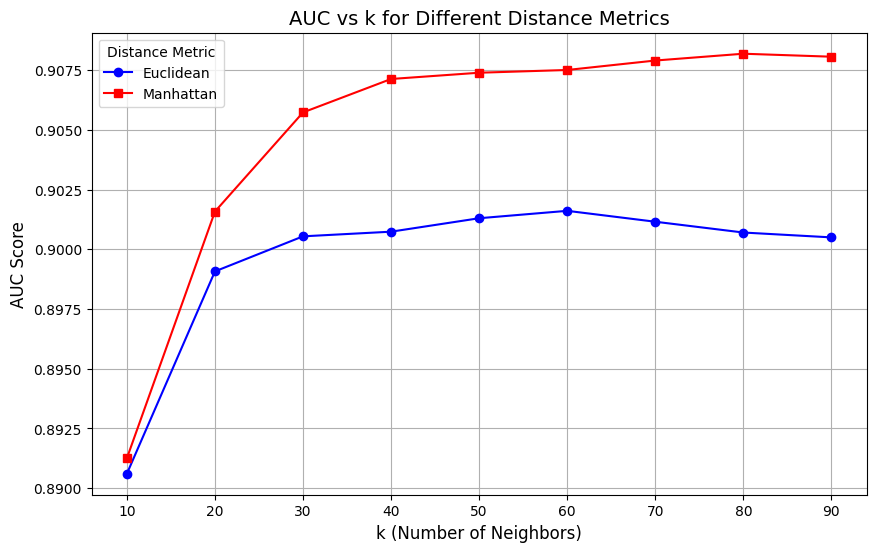

In [16]:
# Hyperparameter tuning for k and distance_metric
best_k = 5
best_metric = 'euclidean'
best_auc = 0

euclidean_aucs = []
manhattan_aucs = []
ek_values_out = []
mk_values_out = []

for k, metric, auc in results:
    if metric == 'euclidean':
        euclidean_aucs.append(auc)
        ek_values_out.append(k)
    elif metric == 'manhattan':
        manhattan_aucs.append(auc)
        mk_values_out.append(k)

    if auc > best_auc:
        best_auc = auc
        best_k = k
        best_metric = metric

print(f"Best k: {best_k}, Best metric: {best_metric}, Best AUC: {best_auc}")


plt.figure(figsize=(10, 6))

ek_values_out = np.asarray(ek_values_out)
mk_values_out = np.asarray(mk_values_out)
euclidean_aucs = np.asarray(euclidean_aucs)
manhattan_aucs = np.asarray(manhattan_aucs)

e_idxs = np.argsort(ek_values_out)
m_idxs = np.argsort(mk_values_out)

ek_values_out = ek_values_out[e_idxs]
mk_values_out = mk_values_out[m_idxs]
euclidean_aucs = euclidean_aucs[e_idxs]
manhattan_aucs = manhattan_aucs[m_idxs]

plt.plot(ek_values_out, euclidean_aucs, marker='o', linestyle='-', color='b', label='Euclidean')
plt.plot(mk_values_out, manhattan_aucs, marker='s', linestyle='-', color='r', label='Manhattan')

plt.title('AUC vs k for Different Distance Metrics', fontsize=14)
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)

plt.legend(title='Distance Metric')

plt.grid(True)
plt.show()

In [18]:
# Train on full dataset with optimal hyperparameters and make predictions on test set
knn = KNN(k=best_k, distance_metric=best_metric)
knn.fit(X, y)
test_predictions = knn.predict(X_test)

# Save test predictions
pd.DataFrame({'id': pd.read_csv('./test.csv')['id'], 'Exited': test_predictions}).to_csv('submissions.csv', index=False)